In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

### Downloading the dataset

In [3]:
!pip install astroquery pandas numpy scikit-learn tensorflow streamlit plotly

from astroquery.jplhorizons import Horizons

  Using cached altair-5.5.0-py3-none-any.whl.metadata (11 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached tenacity-9.1.2-py3-none-any.whl.metadata (1.2 kB)
  Using cached watchdog-6.0.0-py3-none-win_amd64.whl.metadata (44 kB)
  Using cached pydeck-0.9.1-py2.py3-none-any.whl.metadata (4.1 kB)
  Using cached gitdb-4.0.12-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.2-py3-none-any.whl.metadata (4.3 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.1 MB 4.2 MB/s eta 0:00:03
   ---- ----------------------------------- 1.3/11.1 MB 3.5 MB/s eta 0:00:03
   ------ --------------------------------- 1.8/11.1 MB 3.1 MB/s eta 0:00:03
   -------- ------------------------------- 2.4/11.1 MB 3.0 MB/s eta 0:00:03
   ---------- ----------------------------- 2.9/11.1 MB 2.9 MB/s eta 0:00:03
   ------------ --------------------------- 3.4/11.1 MB 2.8 MB/s eta 0:00:03
   ------------

In [17]:
print(data.to_pandas()['datetime_str'].head())


0    A.D. 2010-Jan-01 00:00:00.0000
1    A.D. 2010-Jan-02 00:00:00.0000
2    A.D. 2010-Jan-03 00:00:00.0000
3    A.D. 2010-Jan-04 00:00:00.0000
4    A.D. 2010-Jan-05 00:00:00.0000
Name: datetime_str, dtype: object


#### We remove AD while parsing

In [20]:
from astroquery.jplhorizons import Horizons
import pandas as pd

obj = Horizons(id=399, location='@sun', epochs={'start': '2010-01-01',
                                                'stop': '2030-01-01',
                                                'step': '1d'})
# id is the heliocentric coordinate, Earth is 399 wrt to Sun

data = obj.vectors()
df = data.to_pandas()

df = df[['datetime_str', 'x', 'y', 'z']]
df = df.rename(columns={'datetime_str': 'date'})
df['date'] = df['date'].str.replace('A.D. ', '', regex=False)
df['date'] = pd.to_datetime(df['date'], format='%Y-%b-%d %H:%M:%S.%f', errors='coerce')
df['days_since_start'] = (df['date'] - df['date'].min()).dt.days

df


,date,x,y,z,days_since_start
0,2010-01-01,-0.176018,0.967421,-0.000022,0
1,2010-01-02,-0.193189,0.964128,-0.000021,1
2,2010-01-03,-0.210300,0.960538,-0.000020,2
3,2010-01-04,-0.227347,0.956649,-0.000019,3
4,2010-01-05,-0.244326,0.952464,-0.000019,4
...,...,...,...,...,...
7301,2029-12-28,-0.104613,0.977843,-0.000063,7301
7302,2029-12-29,-0.121984,0.975804,-0.000063,7302
7303,2029-12-30,-0.139318,0.973460,-0.000063,7303
7304,2029-12-31,-0.156611,0.970812,-0.000063,7304


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

##### We are going to convert the dates and date_since_start as cyclic dates as from 0 to 364 again new year starts and converting it into sine and cos ensures that they are cyclic by using 2pi

In [31]:
df['day_of_year'] = df['date'].dt.dayofyear
df['sin_day'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
df['cos_day'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)

X = df[['days_since_start','sin_day','cos_day']].values
y = df[['x','y','z']].values
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

rf=RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

y_pred=rf.predict(X_test)
rmse=np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: ", rmse)

RMSE:  0.0034699207176044


In [34]:
X_scaler=MinMaxScaler()
y_scaler=MinMaxScaler()
X_scaled=X_scaler.fit_transform(X)
y_scaled=y_scaler.fit_transform(y)

X_train, X_test, y_train, y_test=train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

model=Sequential([
    Dense(64, input_shape=(3,), activation='relu'),
    Dense(64, activation='relu'),
    Dense(3)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=300, batch_size=32, verbose=1)

loss = model.evaluate(X_test, y_test)
print("MSE:", loss)


C:\Users\CHANDAN\.conda\envs\tf310\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1097
Epoch 2/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.8054e-04
Epoch 3/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8900e-04
Epoch 4/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3692e-04
Epoch 5/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2234e-04
Epoch 6/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1440e-04
Epoch 7/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1633e-04
Epoch 8/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0960e-04
Epoch 9/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0944e-04
Epoch 10/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1078e-04
Epoch 11/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1020e-04
Epoch 12/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0662e-04
Epoch 13/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0326e-04
Epoch 14/300
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [48]:
y_pred_scaled=model.predict(X_scaled)
y_true_inv = y_scaler.inverse_transform(y_true)
y_pred_inv = y_scaler.inverse_transform(y_pred)

229/229 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


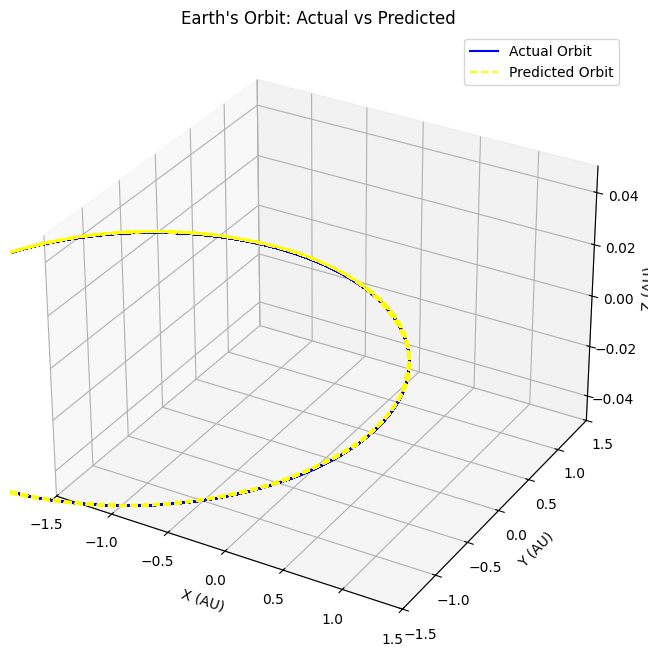

In [50]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.plot(y_true_inv[:,0], y_true_inv[:,1], y_true_inv[:,2], color='blue', label='Actual Orbit')
ax.plot(y_pred_inv[:,0], y_pred_inv[:,1], y_pred_inv[:,2], color='yellow', linestyle='--', label='Predicted Orbit')

ax.set_xlabel('X (AU)')
ax.set_ylabel('Y (AU)')
ax.set_zlabel('Z (AU)')
ax.set_title("Earth's Orbit: Actual vs Predicted")
ax.legend()

ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_zlim([-0.05, 0.05])  

plt.show()
